In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [21]:
import wordninja

# for Latent Dirichlet Allocation (LDA)
from gensim import corpora
from gensim.models import LdaModel

# for tag topic visualisation
import pyLDAvis

# for tag cleaning
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN

In [4]:
products = pd.read_csv('summer_product.csv')
tags = pd.read_csv('product_tags.csv')

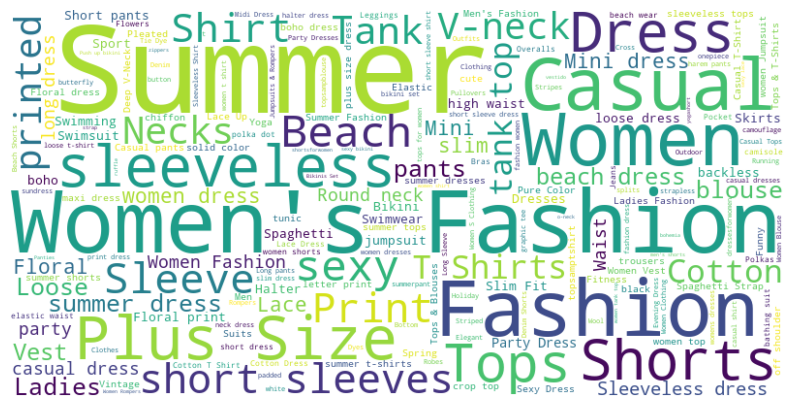

In [5]:
# Visualise tag frequency
tags_frequency = dict(zip(tags['tag'], tags['count']))
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(tags_frequency)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [6]:
# Create a variable representing the number of tags of each products
products['num_tags'] = products['tags'].str.count('\w+')
print(f'Max number of tags assigned to a product: {products['num_tags'].max()}')
print(f'Min number of tags assigned to a product: {products['num_tags'].min()}')

Max number of tags assigned to a product: 59
Min number of tags assigned to a product: 9


In [7]:
tags

,count,tag
0,1321,Summer
1,1315,Women's Fashion
2,1082,Fashion
3,961,Women
4,905,Casual
...,...,...
2615,1,2014menshort
2616,1,"2,piece dress sets"
2617,1,"2,Piece Swimsuit"
2618,1,#fashion #shorts


In [28]:
# function to clean and normalise tags
def clean_tag(tag):
    # Convert to lowercase
    tag = tag.lower()
    
    # Replace special characters (excluding hyphen and underscore)
    tag = re.sub(r"[^a-zA-Z0-9\s_-]", " ", tag)
    
    # Remove extra spaces
    tag = re.sub(r"\s+", " ", tag).strip()
    
    # Split compound words with wordninja
    words = wordninja.split(tag)

    # Rejoin the words if you want to keep it as a single string, otherwise return the list of words
    cleaned_tag = " ".join(words)
    
    return cleaned_tag

In [29]:
tags['cleaned_tags'] = tags['tag'].apply(clean_tag)
tags

,count,tag,cleaned_tags,dbscan_cluster
0,1321,Summer,summer,0
1,1315,Women's Fashion,women s fashion,0
2,1082,Fashion,fashion,0
3,961,Women,women,0
4,905,Casual,casual,0
...,...,...,...,...
2615,1,2014menshort,2014 men short,-1
2616,1,"2,piece dress sets",2 piece dress sets,0
2617,1,"2,Piece Swimsuit",2 piece swimsuit,0
2618,1,#fashion #shorts,fashion shorts,0


In [30]:
# Use TF-IDF to vectorize the cleaned tags
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(tags['cleaned_tags'])

# View the shape of the resulting TF-IDF matrix
print(tfidf_matrix.shape)  # (n_samples, n_features)

(2620, 1229)


In [31]:
# Run DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2, metric='cosine')
dbscan_labels = dbscan.fit_predict(tfidf_matrix)

# Add cluster labels to the DataFrame
tags['dbscan_cluster'] = dbscan_labels

In [34]:
tags['dbscan_cluster'].unique()

array([  0,  -1,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115],
      dtype=int64)

In [32]:
tags[tags['dbscan_cluster'] == -1]['cleaned_tags']

17                 necks
86      top sam pt shirt
108              flowers
111               polkas
140                    t
              ...       
2599                arms
2600             anklets
2604              adidas
2606       5 points pant
2607      3 m reflective
Name: cleaned_tags, Length: 419, dtype: object

## Determine tag category themes

In [35]:
from collections import Counter

# Function to get most frequent words in a cluster
def get_most_frequent_words(tags):
    all_words = ' '.join(tags).split()  # Join all tags and split into individual words
    word_counts = Counter(all_words)  # Count word frequency
    most_common_words = word_counts.most_common(5)  # Get top 5 most frequent words
    return [word for word, count in most_common_words]

# Group tags by cluster and find most frequent words for each cluster
cluster_representatives = {}
for cluster in set(dbscan_labels):  # Assuming 'dbscan_labels' has the cluster labels
    cluster_tags = tags[tags['dbscan_cluster'] == cluster]['cleaned_tags']
    cluster_representatives[cluster] = get_most_frequent_words(cluster_tags)

# View cluster representatives (most common words in each cluster)
cluster_representatives

{0: ['women', 'top', 'shirt', 'dress', 'short'],
 1: ['polka', 'dot', 'dress'],
 2: ['overalls', 'for', 'women'],
 3: ['pocket', 'dre', 's', 'skirt', 'dress'],
 4: ['button', 'top', 'up', 'dre', 's'],
 5: ['tie', 'dye', 'print', 'v', 'shirt'],
 6: ['holiday', 'dre', 's'],
 7: ['robes', 'for', 'women'],
 8: ['retro', 't', 'shirt', 'style'],
 9: ['green', 'dress'],
 10: ['big', 'swing', 'dress', 'code', 'cat'],
 11: ['patchwork', 'dre', 's'],
 12: ['home', 'decor', 'garden', 'living', 'kitchen'],
 13: ['asymmetric', 'dre', 's'],
 14: ['fah', 'sion', 'womens'],
 15: ['bubble', 'ball', 'magic'],
 16: ['gifts', 'for', 'dad'],
 17: ['colorful', 'top'],
 18: ['european', 'style'],
 19: ['vacation', 'dre'],
 20: ['beauty', 'health'],
 21: ['tunics', 'women', 'for'],
 22: ['ruffled', 'top'],
 23: ['plaid', 'checked', 'shirt', 'dress'],
 24: ['mom', 'shirt', 'and', 'kid'],
 25: ['kle', 'id', 'sommer', 'da', 'men'],
 26: ['irregular', 'dre', 'he', 'm', 's'],
 27: ['asymmetrical', 'dress', 'he', '

In [38]:
# Calculate centroids of clusters
cluster_centroids = {}
for cluster in set(dbscan_labels):
    cluster_indices = np.where(dbscan_labels == cluster)[0]
    cluster_vectors = tfidf_matrix[cluster_indices].toarray()
    cluster_centroid = np.mean(cluster_vectors, axis=0)  # Average vector (centroid)
    cluster_centroids[cluster] = cluster_centroid

# Find the tag closest to the centroid (most representative tag)
def find_closest_tag(centroid, cluster_tags, cluster_vectors):
    similarities = cosine_similarity([centroid], cluster_vectors)
    closest_idx = np.argmax(similarities)
    return cluster_tags.iloc[closest_idx]

# Assign the most representative tag for each cluster
representative_tags = {}
for cluster in set(dbscan_labels):
    cluster_tags = tags[tags['dbscan_cluster'] == cluster]['cleaned_tags']
    cluster_indices = np.where(dbscan_labels == cluster)[0]
    cluster_vectors = tfidf_matrix[cluster_indices].toarray()
    representative_tag = find_closest_tag(cluster_centroids[cluster], cluster_tags, cluster_vectors)
    representative_tags[cluster] = representative_tag

# View representative tags for each cluster
representative_tags


{0: 'shirt dress for women',
 1: 'polka dot',
 2: 'overalls for women',
 3: 'pocket',
 4: 'button',
 5: 'tie dye',
 6: 'holiday',
 7: 'robes for women',
 8: 'retro',
 9: 'green',
 10: 'big swing',
 11: 'patchwork',
 12: 'home decor',
 13: 'asymmetric',
 14: 'womens fah sion',
 15: 'magic bubble ball',
 16: 'gifts',
 17: 'colorful',
 18: 'european style',
 19: 'vacation',
 20: 'health beauty',
 21: 'tunics for women',
 22: 'ruffled',
 23: 'plaid',
 24: 'mom shirt',
 25: 'kle id',
 26: 'irregular dre',
 27: 'asymmetrical he m',
 28: 'spaghetti shoulders trap dre',
 29: 'korean style',
 30: 'knit',
 31: 'comfy shirt',
 32: 'music',
 33: 'large size',
 34: 'goth style',
 35: 'sweetheart',
 36: 'package hip dress',
 37: 'lovely',
 38: 'patio decoration',
 39: 'art',
 40: 'moon',
 41: 'hats',
 42: 'graffiti',
 43: 'a line',
 44: 'velvet',
 45: 'usb',
 46: 'under safety pant',
 47: 'tennis',
 48: 'stretch short',
 49: 'slit dre s',
 50: 'casual loosed res',
 51: 'gradient color',
 52: 'nail u

In [39]:
df_representatives = pd.DataFrame({
    'Cluster': list(cluster_representatives.keys()),
    'Most_Frequent_Words': [', '.join(words) for words in cluster_representatives.values()],
    'Closest_To_Centroid': list(representative_tags.values())
})
df_representatives

,Cluster,Most_Frequent_Words,Closest_To_Centroid
0,0,"women, top, shirt, dress, short",shirt dress for women
1,1,"polka, dot, dress",polka dot
2,2,"overalls, for, women",overalls for women
3,3,"pocket, dre, s, skirt, dress",pocket
4,4,"button, top, up, dre, s",button
...,...,...,...
112,112,"belly, dance, pant",belly dance pant
113,113,"anti, mosquito, net, fly",anti mosquito net
114,114,"air, ball, conditioner",air ball
115,115,"massage, relaxation",massage
